# Learning sbi

In [1]:
import torch
import numpy as np

## fast interface

In [ ]:
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 116 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

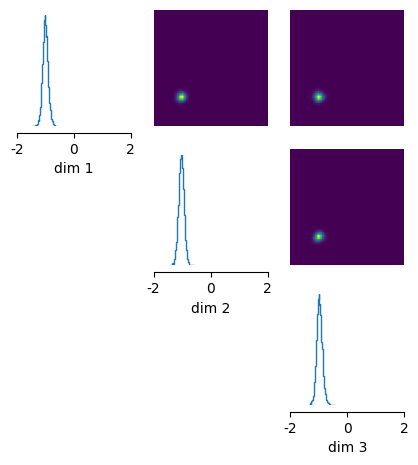

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1
posterior = infer(linear_gaussian, prior, "SNPE", num_simulations=1000)
x_o_1 = torch.zeros(3,)
x_o_2 = 2.0 * torch.ones(3,)
posterior_samples_1 = posterior.sample((10000,), x=x_o_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

In [12]:
prior.sample()

tensor([0.3438, 0.3208, 1.5500])

## flexible interface

In [2]:
import sbi
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
# from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

In [3]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

simulator, prior = prepare_for_sbi(linear_gaussian, prior)
inference = SNPE(prior=prior)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 55 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

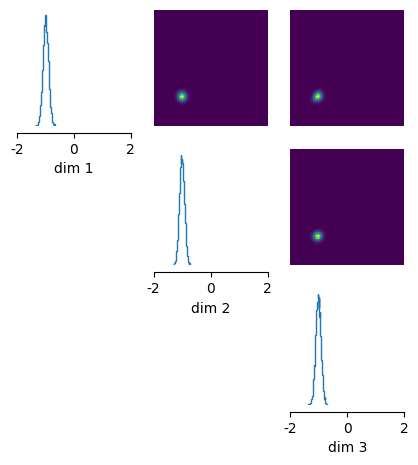

In [4]:
x_o_1 = torch.zeros(3,)
x_o_2 = 2.0 * torch.ones(3,)
posterior_samples_1 = posterior.sample((10000,), x=x_o_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

In [29]:
# Calc Max A Posteriori parameter estimate via gradient ascent given one observation
posterior.set_default_x(x_o_1)
_map = posterior.map(num_iter=2000); _map

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[-1.0214, -1.0065, -0.9915]])

## Handling multiple (assumed iid) observations

In [2]:
import sbi
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi import analysis as analysis

In [35]:
'''This doesn't work bc you need to do a more complicated embedding network thing is using NPE
   Doing so also requires more training data to be accurate according to documentation'''
# x_o_all = torch.stack([x_o_1, x_o_2])
# posterior_samples_all = posterior.sample((10000,), x=x_o_all)

# # plot posterior samples
# _ = analysis.pairplot(
#     posterior_samples_all, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
# )

In [3]:
'''Instead lets use NLE'''
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1
simulator, prior = prepare_for_sbi(linear_gaussian, prior)
inferer = SNLE(prior, show_progress_bars=True, density_estimator="mdn")
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
inferer = inferer.append_simulations(theta, x)
likelihood_estimator = inferer.train()

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 55 epochs.

In [4]:
'''Now try on multiple observations'''
# x_o = torch.zeros(3,)
# x_o = torch.stack([x_o, x_o])
x_o = torch.stack([torch.zeros(3,), torch.zeros(3,), 2.0 * torch.ones(3,)])

In [5]:
# mcmc_parameters = dict(
#     num_chains=50,
#     thin=10,
#     warmup_steps=50,
#     init_strategy="proposal",
# )
# mcmc_method = "slice_np_vectorized"

# posterior = inferer.build_posterior(
#     mcmc_method=mcmc_method,
#     mcmc_parameters=mcmc_parameters,
# )

'''Prefer this more explicit syntax'''
potential_fn, parameter_transform = likelihood_estimator_based_potential(
    likelihood_estimator, prior, x_o
)
posterior = MCMCPosterior(
    potential_fn, proposal=prior, theta_transform=parameter_transform,
    method = "slice_np_vectorized",
    num_chains=50,
    thin=10,
    warmup_steps=50,
    init_strategy="proposal",
)

/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/sbiutils.py:342: UserWarning: An x with a batch size of 3 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


In [6]:
num_samples = 5000
# nle_samples = posterior.sample(sample_shape=(num_samples,), x=x_o)
nle_samples = posterior.sample(sample_shape=(num_samples,))

Running vectorized MCMC with 50 chains:   0%|          | 0/75000 [00:00<?, ?it/s]

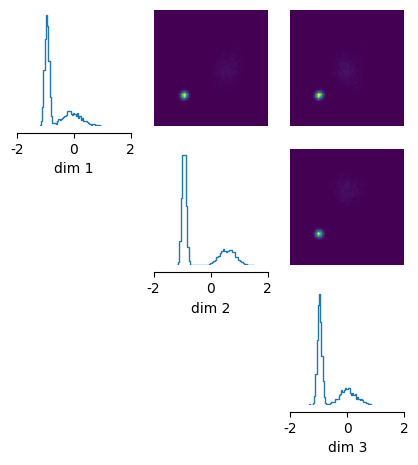

In [7]:
# plot posterior samples
_ = analysis.pairplot(
    nle_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

## Make sure it works if I write simulator in numpy

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 95 epochs.

/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/sbiutils.py:342: UserWarning: An x with a batch size of 3 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


Running vectorized MCMC with 50 chains:   0%|          | 0/75000 [00:00<?, ?it/s]

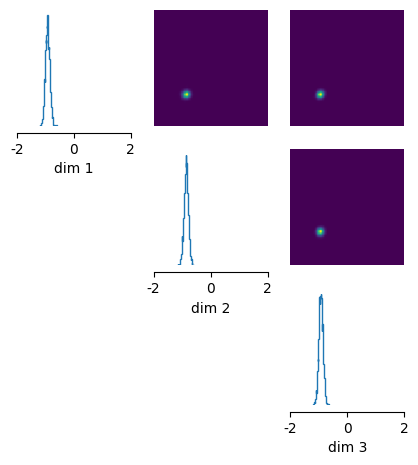

In [3]:
import sbi
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi import analysis as analysis
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
def linear_gaussian(theta):
    # return theta + 1.0 + torch.randn_like(theta) * 0.1
    return theta + 1.0 + np.random.randn(np.shape(theta)[0]) * 0.1
simulator, prior = prepare_for_sbi(linear_gaussian, prior)
# all of the following work
# linear_gaussian(np.zeros(3))
# simulator(torch.tensor([0,0,0]))
# simulator(np.zeros(3))
inferer = SNLE(prior, show_progress_bars=True, density_estimator="mdn")
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
inferer = inferer.append_simulations(theta, x)
likelihood_estimator = inferer.train()
x_o = torch.stack([torch.zeros(3,), torch.zeros(3,), 2.0 * torch.ones(3,)])
potential_fn, parameter_transform = likelihood_estimator_based_potential(
    likelihood_estimator, prior, x_o
)
posterior = MCMCPosterior(
    potential_fn, proposal=prior, theta_transform=parameter_transform,
    method = "slice_np_vectorized",
    num_chains=50,
    thin=10,
    warmup_steps=50,
    init_strategy="proposal",
)
num_samples = 5000
nle_samples = posterior.sample(sample_shape=(num_samples,))
_ = analysis.pairplot(
    nle_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5)
)

# My data

In [1]:
import torch
import numpy as np
import sbi
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
from sbi import utils as utils
from sbi import analysis as analysis
from torch.distributions import Uniform
from sbi.utils import MultipleIndependent
from torch import tensor

If posterior is hopelessly flat, can try fixing some paramters before doing inference. We could justify this well enough for an ecology journal, could argue on basis of 'expert knowledge'.

Could also introduce constraints to the likelihood maximization similar to maxent proccess to account for things estimated from the data (e.g. mortality rates at yr 14) and/or expert knowledge (e.g. Keeley not worried about senescence -> $c_m=0$).

<!-- Here's a continuous time version, parameter labels have changed:
$\frac{\text{d}N}{\text{d}t}=N\Biggl[ \delta_{t,t_{\text{fire}}}~r_f(N,t^*)~+~\Bigr(1-\delta_{t,t_{\text{fire}}}\Bigl)~\Bigl(r(t^*) - m(N,t^*)\Bigr) \Biggr]$

$m(N,t^*)=m(t^*)\Biggl[ 1~+~\frac{\nu(t^*)}{1+\exp{(~-\gamma~(N-K(t^*)A~)}} \Biggr]$, <br /> -->

with $A$ the area inhabitated by the population (aka patch area). For model fitting, assume patch size of $1~\text{ha}$.

If we assume mortality rates are approximately constant between timesteps (not actually valid, especially for young ages, but probably fine for our purposes), the probablity of an individual of age $a-1$ growing to age $a$ is $e^{-m_{a-1}(\vec{N}(t))}$. To add demographic stochasticity, the number of survivors for a given timestep is drawn as: <br /> $\text{num survivors} \sim Bin\Bigl( e^{(-m_{a-1}(\vec{N})~\epsilon_m)},~N_{a-1}(t) \Bigr)$, <br /> with $\epsilon_m$ a lognormally distributed environmental stochasticity term.

Again assuming a constant rate per timestep, the number of seedlings (i.e. 1 yr olds) can similarly be approximated as: <br /> $\text{num offspring} \sim Poi\Bigl( r(t^*)~\epsilon_r,~N(t^*) \Bigr)$.

Reasonable priors for each parameter:
- age-dependent 'baseline' mortality <br /> $m_a = \alpha_m~e^{-\beta_m~a} + \gamma_m$
    - $\alpha_m \sim \mathcal{U}(0.1, 1.8)$  (guess 0.9)
    - $\beta_m \sim \mathcal{U}(0.1, 0.8)$  (guess 0.35)
    - $\gamma_m \sim \mathcal{U}(0,0.1)$  (guess 0.03)
- environmental stochasticity in mortality <br /> $\epsilon_m \sim \text{lognorm}(0,\sigma_m~e^{-\tau_m~a})$
    - $\sigma_m \sim \mathcal{U}(0, 0.6)$ (guess 0.1)
    - $\tau_m \sim \mathcal{U}(0, 0.1)$  (guess 0.02)
<!-- - age-dependent maximum mortality  -->
- age-dependent fractional change in survival <br /> $\nu_a = \alpha_{\nu}~e^{-\beta_{\nu}~a} + \gamma_{\nu}$
    - $\alpha_{\nu} \sim \mathcal{U} (0.2, 1.2)$ (guess 0.61854491)
    - $\beta_{\nu} \sim \mathcal{U} (0.05, 0.5)$ (guess 0.18939423)
    - $\gamma_{\nu} \sim \mathcal{U} (0.01, 0.12)$ (guess 0.08853605)
- age-dependent carrying capacity <br /> $K_a = K_{seedling}~e^{-\kappa~a} + K_{adult}$
    - $K_{seedling} \sim \mathcal{U} (4000, 10000)$ (guess 6000)
    - $\kappa \sim \mathcal{U} (0.15, 0.45)$ (guess 0.3)
    - $K_{adult} \sim \mathcal{U} (700, 1300)$ (guess 1024)
- density dependence 'rate' (i.e. logistic function steepness) <br /> $\eta \sim \mathcal{U} (0.01, 0.15)$ (guess 0.1)
- age-dependent non-fire reproduction rate <br /> $r_a = e^{-\beta_r~a}$
    - $\beta_r \sim \mathcal{U} (0.75,2.5)$ (guess 1.25)
- environmental stochasticity in non-fire reproduction <br /> $\epsilon_r \sim \text{lognorm}(0,\sigma_r~e^{-\tau_r~a})$
    - $\sigma_r \sim \mathcal{U} (0.75, 2)$ (guess 1.4)
    - $\tau_r \sim \mathcal{U} (0.15, 1.5)$

For the simulations, we also need to treat the initial population size as a random parameter:
- Initial population size <br /> $N_1(0) \sim \mathcal{U}(200, 16000)$

In [127]:
priors = [
    # m_a
    Uniform(tensor([0.1]), tensor([1.8])), 
    Uniform(tensor([0.1]), tensor([0.8])),
    Uniform(tensor([0.]), tensor([0.1])),
    # epsilon_m
    Uniform(tensor([0.]), tensor([0.6])),
    Uniform(tensor([0.]), tensor([0.1])),
    # nu_a
    Uniform(tensor([0.2]), tensor([1.2])),
    Uniform(tensor([0.05]), tensor([0.5])),
    Uniform(tensor([0.01]), tensor([0.12])),
    # K_a
    Uniform(tensor([4000.]), tensor([10000.])),
    Uniform(tensor([0.15]), tensor([0.45])),
    Uniform(tensor([700.]), tensor([1300.])),
    # eta
    Uniform(tensor([0.01]), tensor([0.15])),
    # r_a
    Uniform(tensor([0.75]), tensor([2.5])),
    # epsilon_r
    Uniform(tensor([0.75]), tensor([2.])),
    Uniform(tensor([0.15]), tensor([1.5])),
    # N_1(0)
    Uniform(tensor([200.]), tensor([16000.]))
]
prior = MultipleIndependent(priors)

In [28]:
# params = prior.sample().numpy(); params
params = np.array([0.9,0.35,0.03,0.1,0.02,0.6185,0.189,0.088,6000,0.3,1024,0.1,1.25,1.4,0.3,16000])

In [120]:
def simulator(params):
    # Assign parameter labels
    alph_m = params[0]; beta_m = params[1]; gamm_m = params[2]
    sigm_m = params[3]; tau_m = params[4]
    alph_nu = params[5]; beta_nu = params[6]; gamm_nu = params[7]
    K_seedling = params[8]; kappa = params[9]; K_adult = params[10]
    eta = params[11]
    beta_r = params[12]
    sigm_r = params[13]; tau_r = params[14]
    N_1_0 = params[15]
    
    t_vec = np.arange(1,15)
    # print(t_vec)
    N_vec = np.zeros(len(t_vec))
    N_vec[0] = N_1_0
    N_vec = N_vec.astype(int)
    print(N_vec)
    
    m_a = alph_m * np.exp(-beta_m*t_vec) + gamm_m
    # print(m_a) 
    r_a = np.exp(-beta_r*t_vec)
    K_a = K_seedling * np.exp(-kappa*t_vec) + K_adult
    nu_a = alph_nu * np.exp(-beta_nu*t_vec) + gamm_nu
    
    # For generating env stochasticity multipliers
    rng = np.random.default_rng()
    
    for age_i, t in enumerate(t_vec[:-1]):
        dens_dep = ((nu_a)*(1-m_a[age_i])) / (1 + np.exp(-eta*K_adult*(np.sum(N_vec/K_a))))
        # print(dens_dep)
        m_a_N = m_a + dens_dep
        # print(adjusted_m_a)
        epsilon_m = rng.lognormal(np.zeros_like(t_vec), sigm_m*np.exp(-tau_m*t_vec))
        # print(epsilon_m)
        # m_a_N = m_a_N * epsilon_m
        survival_probs = np.exp(-m_a_N * epsilon_m)
        # print(survival_probs)
        num_survivors = rng.binomial(N_vec, survival_probs)
        num_survivors = np.roll(num_survivors, 1)
        # print(num_survivors)
        epsilon_r = rng.lognormal(np.zeros_like(t_vec), sigm_r*np.exp(-tau_r*t_vec))
        # print(r_a * epsilon_r)
        num_births = rng.poisson(r_a*epsilon_r*N_vec)
        print(num_births)
        break

In [126]:
simulator(params)

[16000     0     0     0     0     0     0     0     0     0     0     0
     0     0]
[574   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [62]:
test = np.array([2.1])

In [63]:
test.astype(int)

array([2])

In [33]:
rng = np.random.default_rng()

In [19]:
rng.binomial([10,100,1000], [0.5,0.25,0.1])

array([  6,  17, 104])

In [79]:
samp = test.sample(); samp.shape

torch.Size([16])

In [80]:
utils.user_input_checks.process_prior(test)

(MultipleIndependent(), 16, False)

In [75]:
samp = test.sample(sample_shape=torch.Size([1500, 15]))

In [25]:
rng = np.random.default_rng()
N0 = rng.uniform(200, 16000); N0

3934.4782197124764